---
title: Working with pyCATHY and DA with ERT datasets
subtitle: PART3 - plotting the results
license: CC-BY-4.0
github: https://github.com/BenjMy/ETH_pyCATHY/
subject: Tutorial
authors:
  - name: Benjamin Mary
    email: benjamin.mary@ica.csic.es
    corresponding: true
    orcid: 0000-0001-7199-2885
    affiliations:
      - ICA-CSIC
date: 2024/04/12
---

The notebooks describe: 

**Plot outputs**: analysis of the results
   - [Saturation with uncertainties](plot_states)
   - [Parameters convergence](Parm_evol)
   - [Assimilation performance](DA_perf)

In [27]:
import pyCATHY
from pyCATHY import cathy_tools
from pyCATHY.DA.cathy_DA import DA, dictObs_2pd
from pyCATHY.DA.perturbate import perturbate_parm
from pyCATHY.DA import perturbate
from pyCATHY.DA.observations import read_observations, prepare_observations, make_data_cov
from pyCATHY.DA import performance
import pyvista as pv
import pyCATHY.plotters.cathy_plots as cplt 
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# set some default plotting parameters for nicer looking plots
mpl.rcParams.update({"axes.grid":True, 
                     "grid.color":"gray", 
                     "grid.linestyle":'--',
                     'figure.figsize':(6,6)}
                   )
import pandas as pd
import utils

In [28]:
import pygimli as pg 
from pygimli.physics import ert

In [29]:
import ipywidgets as widgets

(plot_results)=
# Analysis of the results

In [30]:
choose_simulation = widgets.Select(
                                    options=['ERTp1_withDA', 
                                             'ERTp1_withoutDA',
                                             'ERTp2_withDA',
                                             'ERTp2_withoutDA',
                                            ],
                                    value='ERTp1_withDA',
                                    description='DA type:',
                                    disabled=False
                                )

In [31]:
choose_simulation

Select(description='DA type:', options=('ERTp1_withDA', 'ERTp1_withoutDA', 'ERTp2_withDA', 'ERTp2_withoutDA'),…

## Reload solution

In [32]:
simu_solution = cathy_tools.CATHY(
                                    dirName='./solution_ERT',
                                    prj_name= 'weill_dataset',
                                    notebook=True,
                                  )
sw_SOL, sw_SOL_times = simu_solution.read_outputs('sw')
psi_SOL = simu_solution.read_outputs('psi')

rootMap, rootMap_hd = simu_solution.read_inputs('root_map')

soil_SPP_SOL, soil_FP_SOL = simu_solution.read_inputs('soil',
                                                         MAXVEG=int(np.max(rootMap)),
                                                    )
PERMX_SOL = soil_SPP_SOL['PERMX'].unique()[0]
POROS_SOL = soil_SPP_SOL['POROS'].unique()[0]

🏁 Initiate CATHY object

plot pressure


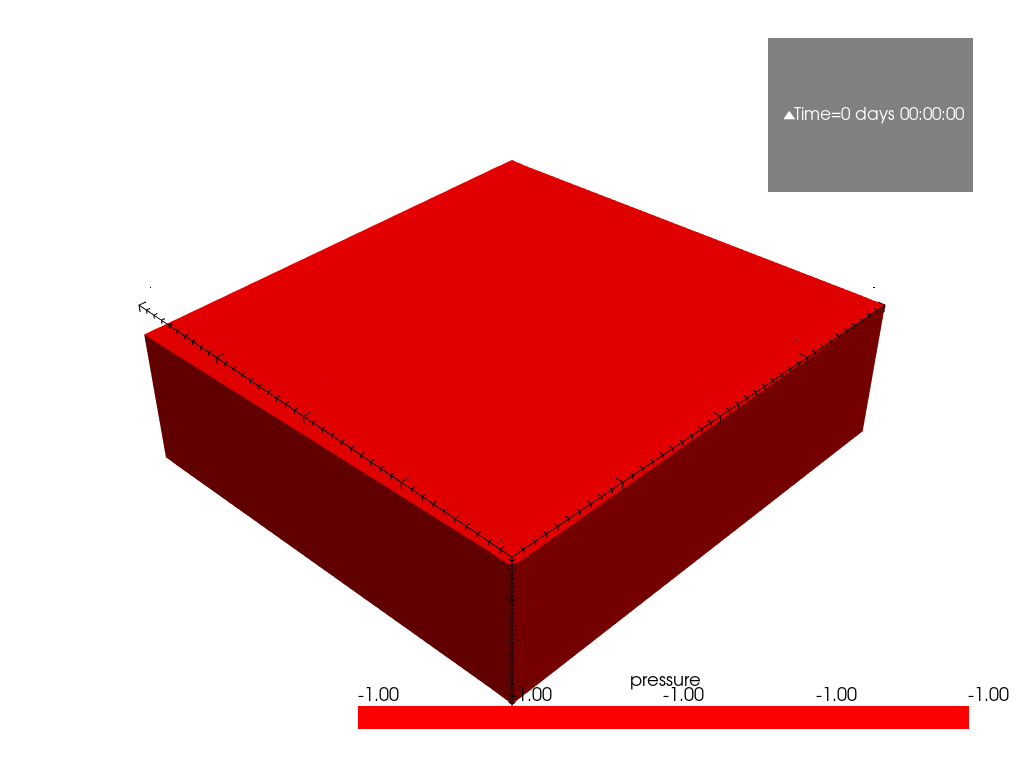

In [33]:
pl = pv.Plotter(notebook=True)
cplt.show_vtk(unit="pressure", 
              timeStep=0, 
              path=simu_solution.workdir + "/weill_dataset/vtk/",
              ax=pl,
              )
pl.show()

In [34]:
simu_solution.workdir

'/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/./solution_ERT'

## Reload DA results

In [35]:
simuDA = DA(
            dirName='./DA_ERT',
            prj_name= choose_simulation.value,
            notebook=True,
        )

🏁 Initiate CATHY object

In [36]:
results_DA = simuDA.load_pickle_backup()

In [37]:
observations = dictObs_2pd(results_DA['dict_obs'])

In [38]:
observations.xs('ERT',0).iloc[0]['data'].head()

,a,b,m,n,k,r,rhoa,err,valid
0,0,1,2,3,-9.424778,0.0,21.970278,0.01,1.0
1,1,2,3,4,-9.424778,0.0,27.329196,0.01,1.0
2,2,3,4,5,-9.424778,0.0,28.257720,0.01,1.0
3,3,4,5,6,-9.424778,0.0,28.448607,0.01,1.0
4,4,5,6,7,-9.424778,0.0,29.171831,0.01,1.0


In [39]:
nodes_of_interest = [[220], [1984], [3307]]

In [40]:
meshCiPG_PGref = pv.read('./solution_ERT/meshCi.vtk')
meshLiPG_PGref = pv.read('./solution_ERT/meshLi.vtk')

yshift = 8
xshift = 8

(meshCiPG, meshLiPG) = utils.define_mesh_transformations(meshCiPG_PGref,
                                                          meshLiPG_PGref,
                                                          idC=yshift, 
                                                          idL=xshift,
                                                        )
pt1, _ = simu_solution.find_nearest_node([0,yshift,meshLiPG.points[:,2].max()])
pt2, _ = simu_solution.find_nearest_node([5,yshift,meshLiPG.points[:,2].max()])
pt3, _ = simu_solution.find_nearest_node([10,yshift,meshLiPG.points[:,2].max()])
#nodes_of_interest = [pt1,pt2,pt3]
#nodes_of_interest

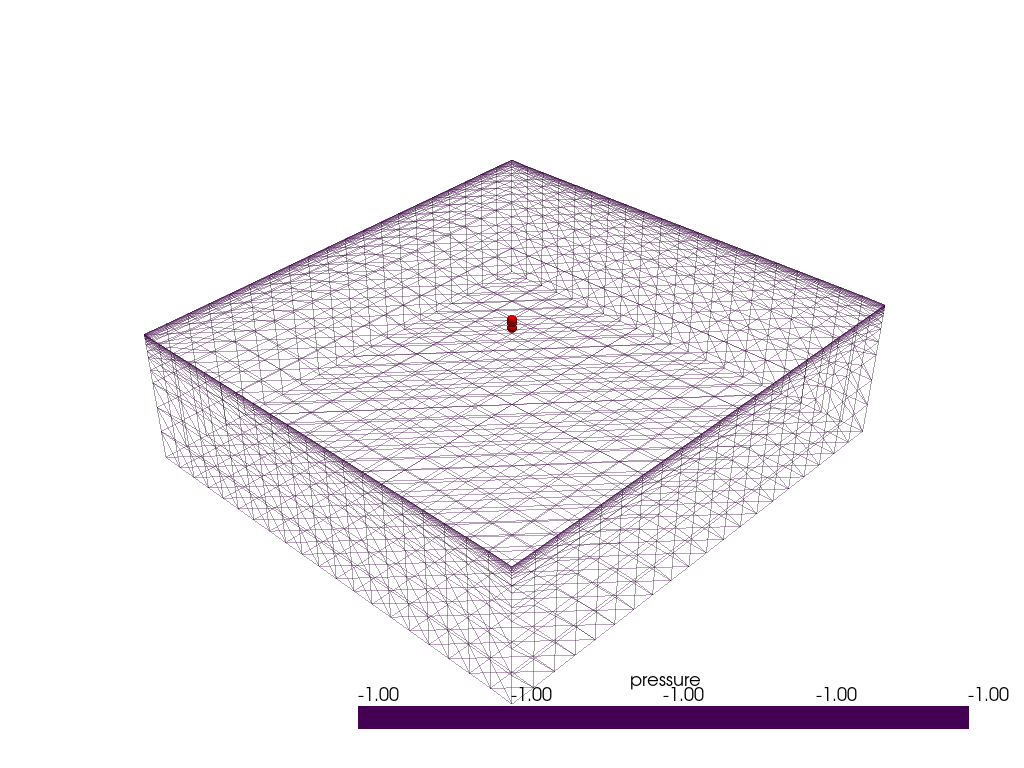

In [41]:
pl = pv.Plotter(notebook=True)

mesh = pv.read(os.path.join(simu_solution.workdir,
                            simu_solution.project_name,
                                'vtk/100.vtk',
                               )
       )

pl.add_mesh(mesh,
           opacity=0.2,
           style="wireframe",
           )

for nn in nodes_of_interest:
    pl.add_points(mesh.points[nn],
                  color='red',
                  render_points_as_spheres=True,
                  point_size=10
                  )
pl.show()

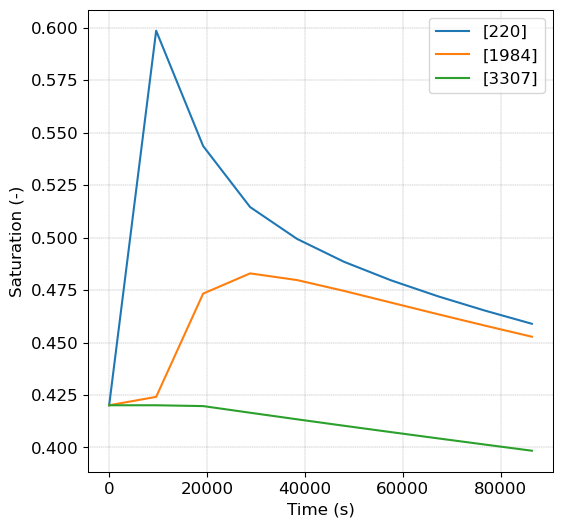

In [42]:
df_sw, sw_times = simu_solution.read_outputs('sw')

fig, ax = plt.subplots()
for nn in nodes_of_interest:
    ax.plot(df_sw.index,
            df_sw[nn],
            label=nn
            )
ax.set_xlabel('Time (s)')
ax.set_ylabel('Saturation (-)')
plt.legend()


In [43]:
assimilation_times = observations.index.get_level_values(1).unique().to_list()
assimilation_times

[0.0,
 9600.0,
 19200.0,
 28800.0,
 38400.0,
 48000.0,
 57600.0,
 67200.0,
 76800.0,
 86400.0]

(plot_states)=
## Plot model saturation with uncertainties 

In [44]:
parm_df = pd.DataFrame.from_dict(results_DA['dict_parm_pert'],
                                 orient='index').T
parm_df

,ic,ZROOT0
type_parm,ic,ZROOT0
nominal,-1.0,0.4
mean,-1.0,0.4
sd,1.75,0.005
units,pressure head $(m)$,$m$
sampling_type,normal,normal
ensemble_size,32,32
per_type,None,None
savefig,ic.png,ZROOT0.png
sampling_mean,-1.0,0.4


(array([2., 0., 2., 6., 5., 5., 3., 4., 2., 3.]),
 array([-5.02769272, -4.31958139, -3.61147006, -2.90335873, -2.1952474 ,
        -1.48713607, -0.77902474, -0.0709134 ,  0.63719793,  1.34530926,
         2.05342059]),
 <BarContainer object of 10 artists>)

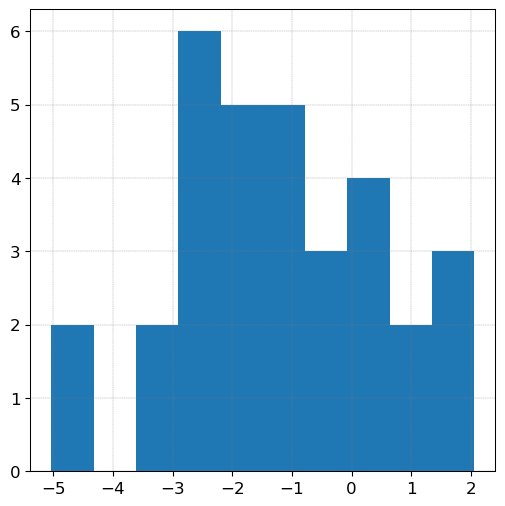

In [45]:
fig, ax = plt.subplots()
ax.hist(parm_df['ic']['ini_perturbation'])

In [46]:
#obs2plot = observations.xs('swc',level=0)
obs2plot = observations
obs2plot['saturation'] = obs2plot['data']/POROS_SOL

In [47]:
unique_times = results_DA['df_DA']["time"].unique()
results_DA['df_DA']["assimilation_times"] = results_DA['df_DA']["time"].map(dict(zip(unique_times, 
                                                                               assimilation_times))
                                                                     )

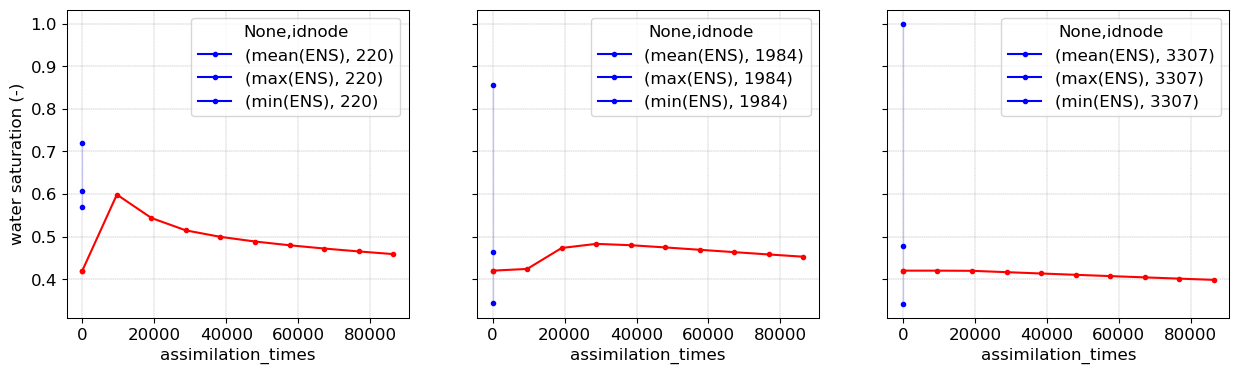

In [48]:
fig, axs = plt.subplots(1,3,figsize=(15,4),
                       sharey=True
                       )
for axi, NOI in zip(axs, nodes_of_interest):
    cplt.DA_plot_time_dynamic(results_DA['df_DA'],
                              'sw',
                              NOI,
                              ax=axi,
                              keytime='assimilation_times',
                              )  
    axi.plot(sw_SOL.index,
            sw_SOL.iloc[:,NOI],
            color='r',
            marker= '.'
            )

In [49]:
unique_times = results_DA['df_DA']["time"].unique() -1
results_DA['df_DA']["assimilation_times"] = results_DA['df_DA']["time"].map(dict(zip(unique_times, 
                                                                               assimilation_times))
                                                                     )

TypeError: no numeric data to plot

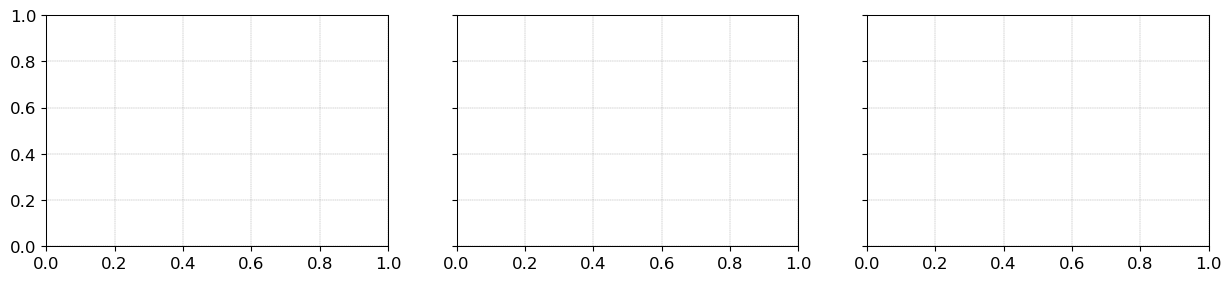

In [50]:
fig, axs = plt.subplots(1,3,figsize=(15,3),
                       sharey=True
                       )
for axi, NOI in zip(axs, nodes_of_interest):
    cplt.DA_plot_time_dynamic(results_DA['df_DA'],
                              'sw',
                              NOI,
                              ax=axi,
                              keytime='assimilation_times',
                              )  
    axi.plot(sw_SOL.index,
            sw_SOL.iloc[:,NOI],
            color='r',
            marker= '.'
            )

(DA_perf)= 
## Plot DA performance

/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/pycathy_wrapper/pyCATHY/plotters/cathy_plots.py:1455: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_plot["RMSE" + sensorName] = df_perf_plot["RMSE" + sensorName].astype(
/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/pycathy_wrapper/pyCATHY/plotters/cathy_plots.py:1458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_plot["NMRMSE" + sensorName] = df_perf_plot["NMRMSE" + sensorName].astype(
/home/z0272571a@CAMPUS.CSIC.

(array([<Axes: xlabel='assimilation #', ylabel='RMSEERT'>,
        <Axes: xlabel='assimilation #', ylabel='NMRMSEERT'>], dtype=object),
 <module 'matplotlib.pyplot' from '/home/z0272571a@CAMPUS.CSIC.ES/miniconda3/envs/pgCATHY/lib/python3.11/site-packages/matplotlib/pyplot.py'>)

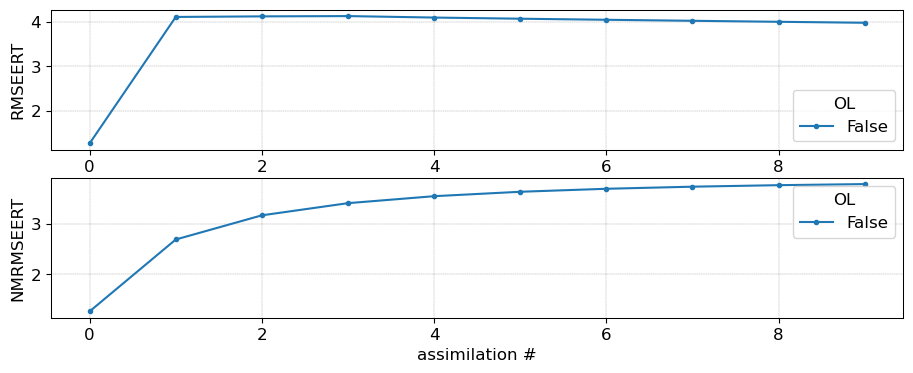

In [25]:
fig, ax = plt.subplots(2,figsize=[11,4])
cplt.DA_RMS(results_DA['df_performance'],'ERT',ax=ax)

(Parm_evol)=
## Plot parameters convergence

KeyError: 'ZROOT'

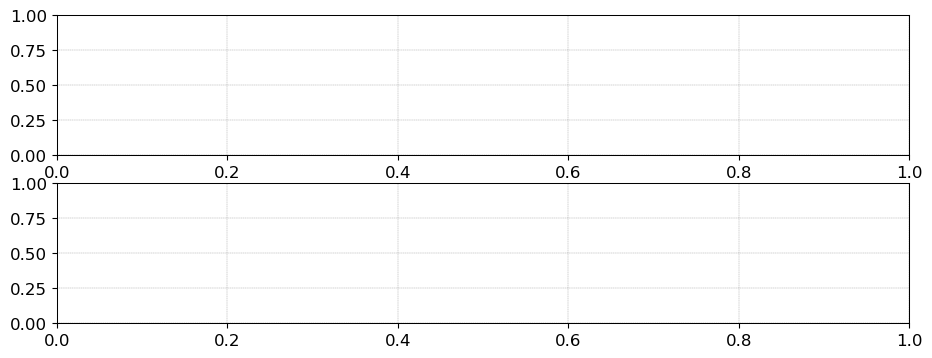

In [26]:
fig, axs = plt.subplots(2,1,figsize=[11,4],
                        # sharex=True
                        )
cplt.DA_plot_parm_dynamic_scatter(parm = 'ZROOT', 
                                  dict_parm_pert=results_DA['dict_parm_pert'], 
                                  list_assimilation_times = assimilation_times,
                                  ax=axs[0],
                                          )   
axs[0].plot(np.linspace(1,len(assimilation_times), len(assimilation_times)),
            [POROS_SOL]*len(assimilation_times))
